## Supplementary materials for portfolio optimization

In [1]:
import pandas as pd
# the yahoo-finance package let's us download asset data 
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sco
from scipy import stats

np.random.seed(2718)

In [2]:
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker[:-3] for ticker in tickers])
        
    return results_df

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aee9be81da0>,
      dtype=object)

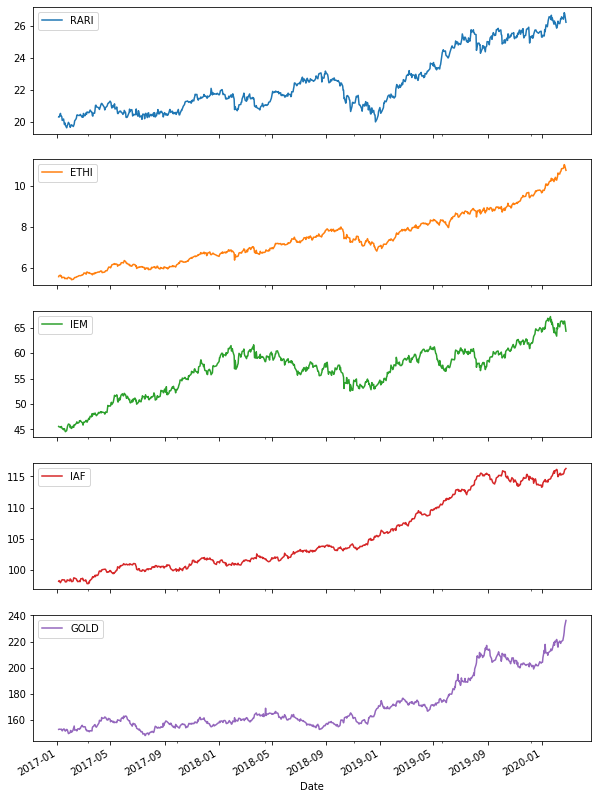

In [3]:
tickers = ['RARI.AX','ETHI.AX','IEM.AX','IAF.AX','GOLD.AX'] # also check out VAS and IOO instead of RARI and ETHI

for tic in tickers:
    #get data on this ticker
    ticker = yf.Ticker(tic)
    #get the historical prices for this ticker
    tickerdf = ticker.history(period='max', end='2020-02-25')[['Close']]
    tickerdf.rename(columns={'Close': tic[:-3]}, inplace=True)
    if tic == 'RARI.AX':
        df = tickerdf
    else:
        df = df.join(tickerdf, how='inner', rsuffix='_'+tic)

df.plot(subplots=True, figsize=(10,15))

In [4]:
returns = df.pct_change()

In [5]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.3/100

In [6]:
def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def max_sharpe_ratio(mean_returns, cov, rf, bounds=None):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    if bounds == None:
        bound = (0.0,1.0)
        bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

optimal_port_sharpe = max_sharpe_ratio(mean_returns, cov, rf)

In [7]:
def calc_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    return portfolio_std

def min_variance(mean_returns, cov, bounds=None):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    if bounds == None:
        bound = (0.0,1.0)
        bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

min_port_variance = min_variance(mean_returns, cov)

In [8]:
def efficient_return(mean_returns, cov, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    rf = 0.0 #does not matter because we are not using the sharpe ratio here
    
    def portfolio_return(weights):
        return calc_portfolio_perf(weights, mean_returns, cov, rf)[0]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov, ret))
    return efficients

## Higher return optimal portfolios

In [9]:
optimal_ret_x_port = efficient_return(mean_returns, cov, target=0.09)
weights = optimal_ret_x_port['x']
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf=0.3/100)
print('Most optimal portfolio with 9 percent return:')
print(pd.DataFrame(weights,index=df.columns).T)
print('std dev = %5.4f, sharpe ratio = %5.4f' % (std, sharpe))

Most optimal portfolio with 9 percent return:
      RARI      ETHI       IEM       IAF      GOLD
0  0.01135  0.166393  0.004206  0.732163  0.085888
std dev = 0.0317, sharpe ratio = 2.7403


In [10]:
optimal_ret_x_port = efficient_return(mean_returns, cov, target=0.095)
weights = optimal_ret_x_port['x']
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf=0.3/100)
print('Most optimal portfolio with 9.5 percent return:')
print(pd.DataFrame(weights,index=df.columns).T)
print('std dev = %5.4f, sharpe ratio = %5.4f' % (std, sharpe))

Most optimal portfolio with 9.5 percent return:
       RARI      ETHI  IEM       IAF      GOLD
0  0.006968  0.189808  0.0  0.700185  0.103039
std dev = 0.0336, sharpe ratio = 2.7355


In [11]:
optimal_ret_x_port = efficient_return(mean_returns, cov, target=0.1)
weights = optimal_ret_x_port['x']
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf=0.3/100)
print('Most optimal portfolio with 10 percent return:')
print(pd.DataFrame(weights,index=df.columns).T)
print('std dev = %5.4f, sharpe ratio = %5.4f' % (std, sharpe))

Most optimal portfolio with 10 percent return:
       RARI      ETHI  IEM       IAF      GOLD
0  0.001356  0.211284  0.0  0.666207  0.121153
std dev = 0.0357, sharpe ratio = 2.7198


In [12]:
optimal_ret_x_port = efficient_return(mean_returns, cov, target=0.105)
weights = optimal_ret_x_port['x']
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf=0.3/100)
print('Most optimal portfolio with 10.5 percent return:')
print(pd.DataFrame(weights,index=df.columns).T)
print('std dev = %5.4f, sharpe ratio = %5.4f' % (std, sharpe))

Most optimal portfolio with 10.5 percent return:
   RARI      ETHI           IEM       IAF      GOLD
0   0.0  0.231241  4.336809e-19  0.628316  0.140443
std dev = 0.0378, sharpe ratio = 2.6963


In [13]:
optimal_ret_x_port = efficient_return(mean_returns, cov, target=0.11)
weights = optimal_ret_x_port['x']
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf=0.3/100)
print('Most optimal portfolio with 11 percent return:')
print(pd.DataFrame(weights,index=df.columns).T)
print('std dev = %5.4f, sharpe ratio = %5.4f' % (std, sharpe))

Most optimal portfolio with 11 percent return:
           RARI      ETHI           IEM       IAF      GOLD
0  4.336809e-18  0.250796  1.734723e-18  0.589245  0.159959
std dev = 0.0401, sharpe ratio = 2.6678


In [14]:
optimal_ret_x_port = efficient_return(mean_returns, cov, target=0.12)
weights = optimal_ret_x_port['x']
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf=0.3/100)
print('Most optimal portfolio with 12 percent return:')
print(pd.DataFrame(weights,index=df.columns).T)
print('std dev = %5.4f, sharpe ratio = %5.4f' % (std, sharpe))

Most optimal portfolio with 12 percent return:
           RARI      ETHI  IEM       IAF      GOLD
0  8.463985e-18  0.289272  0.0  0.510589  0.200139
std dev = 0.0449, sharpe ratio = 2.6035


In [15]:
optimal_ret_x_port = efficient_return(mean_returns, cov, target=0.13)
weights = optimal_ret_x_port['x']
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf=0.3/100)
print('Most optimal portfolio with 13 percent return:')
print(pd.DataFrame(weights,index=df.columns).T)
print('std dev = %5.4f, sharpe ratio = %5.4f' % (std, sharpe))

Most optimal portfolio with 13 percent return:
   RARI      ETHI  IEM       IAF      GOLD
0   0.0  0.328225  0.0  0.432319  0.239456
std dev = 0.0500, sharpe ratio = 2.5375


## Scipy optimize with varying bounds for each portfolio

In [16]:
bounds = ((0.15,1),(0.0,1.0),(0.1,1),(0.0,1.0),(0.0,1.0))
bound_max_sharpe_port = max_sharpe_ratio(mean_returns, cov, rf, bounds)

In [17]:
pd.DataFrame([round(x,4) for x in bound_max_sharpe_port['x']],index=tickers).T

,RARI.AX,ETHI.AX,IEM.AX,IAF.AX,GOLD.AX
0,0.15,0.0868,0.1,0.4869,0.1763


In [18]:
weights = np.array([x for x in bound_max_sharpe_port['x']])
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf)

print('Max sharpe portfolio return = %5.4f, std dev = %5.4f, sharpe ratio = %5.4f' % (ret, std, sharpe))

Max sharpe portfolio return = 0.0960, std dev = 0.0391, sharpe ratio = 2.3766


In [19]:
bounds = ((0.1,1),(0.0,1.0),(0.1,1),(0.0,1.0),(0.0,1.0))
bound_max_sharpe_port = max_sharpe_ratio(mean_returns, cov, rf, bounds)

In [20]:
pd.DataFrame([round(x,4) for x in bound_max_sharpe_port['x']],index=tickers).T

,RARI.AX,ETHI.AX,IEM.AX,IAF.AX,GOLD.AX
0,0.1,0.0884,0.1,0.5675,0.1442


In [21]:
weights = np.array([x for x in bound_max_sharpe_port['x']])
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf)

print('Max sharpe portfolio return = %5.4f, std dev = %5.4f, sharpe ratio = %5.4f' % (ret, std, sharpe))

Max sharpe portfolio return = 0.0917, std dev = 0.0357, sharpe ratio = 2.4848


In [22]:
bounds = ((0.1,1),(0.1,1.0),(0.1,1),(0.0,1.0),(0.0,1))
bound_max_sharpe_port = max_sharpe_ratio(mean_returns, cov, rf, bounds)

In [23]:
pd.DataFrame([round(x,4) for x in bound_max_sharpe_port['x']],index=tickers).T

,RARI.AX,ETHI.AX,IEM.AX,IAF.AX,GOLD.AX
0,0.1,0.1,0.1,0.5497,0.1503


In [24]:
weights = np.array([x for x in bound_max_sharpe_port['x']])
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf)

print('Max sharpe portfolio return = %5.4f, std dev = %5.4f, sharpe ratio = %5.4f' % (ret, std, sharpe))

Max sharpe portfolio return = 0.0941, std dev = 0.0367, sharpe ratio = 2.4834


In [25]:
bounds = ((0.1,1),(0.1,1.0),(0.1,1),(0.1,1.0),(0.1,1))
bound_max_sharpe_port = max_sharpe_ratio(mean_returns, cov, rf, bounds)

In [26]:
pd.DataFrame([round(x,4) for x in bound_max_sharpe_port['x']],index=tickers).T

,RARI.AX,ETHI.AX,IEM.AX,IAF.AX,GOLD.AX
0,0.1,0.1,0.1,0.5497,0.1503


In [27]:
weights = np.array([x for x in bound_max_sharpe_port['x']])
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf)

print('Max sharpe portfolio return = %5.4f, std dev = %5.4f, sharpe ratio = %5.4f' % (ret, std, sharpe))

Max sharpe portfolio return = 0.0941, std dev = 0.0367, sharpe ratio = 2.4834


In [28]:
bounds = ((0.05,1),(0.05,1.0),(0.05,1),(0.05,1.0),(0.05,1))
bound_max_sharpe_port = max_sharpe_ratio(mean_returns, cov, rf, bounds)

In [29]:
pd.DataFrame([round(x,4) for x in bound_max_sharpe_port['x']],index=tickers).T

,RARI.AX,ETHI.AX,IEM.AX,IAF.AX,GOLD.AX
0,0.05,0.1209,0.05,0.6763,0.1028


In [30]:
weights = np.array([x for x in bound_max_sharpe_port['x']])
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf)

print('Max sharpe portfolio return = %5.4f, std dev = %5.4f, sharpe ratio = %5.4f' % (ret, std, sharpe))

Max sharpe portfolio return = 0.0883, std dev = 0.0318, sharpe ratio = 2.6803


In [31]:
bounds = ((0.08,1),(0.08,1.0),(0.08,1),(0.08,1.0),(0.08,1))
bound_max_sharpe_port = max_sharpe_ratio(mean_returns, cov, rf, bounds)

In [32]:
pd.DataFrame([round(x,4) for x in bound_max_sharpe_port['x']],index=tickers).T

,RARI.AX,ETHI.AX,IEM.AX,IAF.AX,GOLD.AX
0,0.08,0.098,0.08,0.6179,0.124


In [33]:
weights = np.array([x for x in bound_max_sharpe_port['x']])
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf)

print('Max sharpe portfolio return = %5.4f, std dev = %5.4f, sharpe ratio = %5.4f' % (ret, std, sharpe))

Max sharpe portfolio return = 0.0894, std dev = 0.0336, sharpe ratio = 2.5742


In [34]:
weights = np.array([0.1406,0.1970,0.1809,0.3473,0.1319])
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf)

print('Max sharpe portfolio return = %5.4f, std dev = %5.4f, sharpe ratio = %5.4f' % (ret, std, sharpe))

Max sharpe portfolio return = 0.1149, std dev = 0.0549, sharpe ratio = 2.0387


In [35]:
weights = np.array([0.1406,0.1970,0.1,0.3473+0.0809,0.1319])
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf)

print('Max sharpe portfolio return = %5.4f, std dev = %5.4f, sharpe ratio = %5.4f' % (ret, std, sharpe))

Max sharpe portfolio return = 0.1097, std dev = 0.0470, sharpe ratio = 2.2709


In [36]:
weights = np.array([0.1,0.1,0.197,0.3473+0.0809+0.0406,0.1319])
ret, std, sharpe = calc_portfolio_perf(weights, mean_returns, cov, rf)

print('Max sharpe portfolio return = %5.4f, std dev = %5.4f, sharpe ratio = %5.4f' % (ret, std, sharpe))

Max sharpe portfolio return = 0.0986, std dev = 0.0446, sharpe ratio = 2.1455
